<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Propagate random and systematic uncertainty in radiance and irradiance to **reflectance** in the `punpy` Monte Carlo framework

# Prerequisites

- Understanding of Piccolo spectrometer data processing explained in [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)
- Understanding of random and systematic uncertainty propagation during the radiometric correction process [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)

*code from those notebooks is provided below without any explanation, pease refer to the respective notebook if something is unclear*

# TOC

1. [Introduction](#1)
2. [Piccolo data reading](#2)
3. [Propagation of uncertainty in radiance (L) and irradiance (E)](#3)
4. [Propagation of uncertainty in reflectance (practice)](#4)
   1. [4-0](#4-0) Monte Carlo sampler definition
   2. [4-1](#4-1) model function definition
   3. [4-2](#4-2) mean value computation
   4. [4-3](#4-3) random uncertainty (U$_R$)
   5. [4-4](#4-4) systematic uncertainty (U$_S$)
   6. [4-5](#4-5) total uncertainty (U$_T$)
   7. [4-6](#4-6) plotting
   8. [4-7](#4-7) export
5. [Correlation matrices (FYI)](#5)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 2
## Piccolo data reading

For details on data reading, please, refer to the notebook [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

Reflectance measurements using a spectrometer system (Piccolo doppio)

[back to TOC](#TOC)

In [39]:
data_dir = Path(r'../data/case1-set1')

data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

In [40]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [41]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### Irradiance (E)

In [42]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


#### Integration time correction

In [43]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [44]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

# 3

## Propagation of uncertainty in radiance (L) and irradiance (E)

[back to TOC](#TOC)

For details on data reading, please, refer to the notebook [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)

In [45]:
prop = punpy.MCPropagation(10000)

## propagation function
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

### radiance (L)

In [46]:
## mean value
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0)

## random uncertainty
L0_ur = np.std(L0, axis=1) / (N_L**0.5) 
dark_L0_ur = np.std(dark_L0, axis=1) / (M_L**0.5)

## propagtaion of U_R
L1_ur = prop.propagate_random(calibrate,
                              [L0_m, dark_L0_m, cal_coef_L0],
                              [L0_ur, dark_L0_ur, np.zeros(len(Wvl))])  


## systematic uncertainty
L0_assumed_us_perc = 3 # in percents
L0_cert_us_rel = np.ones(len(Wvl)) * L0_assumed_us_perc / 100
cCalL_us_abs = L0_cert_us_rel * cal_coef_L0  # is the absolute uncertainty of the standard instrument used for calibration

## propagtaion of U_S
L1_us = prop.propagate_systematic(calibrate, 
                                  [L0_m, dark_L0_m, cal_coef_L0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalL_us_abs])

### irradiance (E)

In [47]:
## mean value
E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)

E1 = calibrate(E0_m, dark_E0_m, cal_coef_E0)

## random uncertainty
E0_ur = np.std(E0, axis=1) / (N_E ** 0.5) 
dark_E0_ur = np.std(dark_E0, axis=1) / (M_E ** 0.5)

## propagtaion of U_R
E1_ur = prop.propagate_random(calibrate,
                              [E0_m, dark_E0_m, cal_coef_E0],
                              [E0_ur, dark_E0_ur, np.zeros(len(Wvl))])  


## systematic uncertainty
E0_assumed_us_perc = 3 # in percents
E0_cert_us_rel = np.ones(len(Wvl)) * E0_assumed_us_perc / 100
cCalE_us_abs = E0_cert_us_rel * cal_coef_E0  # is the absolute uncertainty of the standard instrument used for calibration

## propagtaion of U_S
E1_us = prop.propagate_systematic(calibrate, 
                                  [E0_m, dark_E0_m, cal_coef_E0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalE_us_abs])

# 4
## Propagation of uncertainty in reflectance (practice)

[back to TOC](#TOC)

Conceptually there is nothing different from the case described in the notebook [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)

We stil propagate random ($U_R$) and systematic ($U_S$) uncertainties of input components to the total uncertainty ($U_T$) in the reflectance

Now, the propagation is done through a function:

```python
def deriveR(L, E):
    return  (np.pi * L) / E
```

Analysis of the function `deriveR` shows that we have to conduct two mathematical operations to come from calibrated radiance and irradiance to reflectance (also called **absolute reflectance (R1)** because computed from calibrated [in SI units of W m-2 nm-1] L and E)
- multiplication by a constant [$\pi$]
- division [of radiance to irradiance]

## 4-0
### MC sampler definition

[back to TOC](#TOC)

for rubustness we will draw 10 000 samples from the PDFs

In [48]:
prop = punpy.MCPropagation(10000)

## 4-1
### model function definition

[back to TOC](#TOC)

In [49]:
def deriveR(L, E):
    return  (np.pi * L) / E

## 4-2
### mean value computation

[back to TOC](#TOC)

In [50]:
R1 = deriveR(L1, E1)

## 4-3 
### random uncertainty propagation $U_R$

[back to TOC](#TOC)

random uncertainties are uncorrelated


In [51]:
R1_ur = prop.propagate_random(deriveR, 
                              [L1, E1],
                              [L1_ur,E1_ur])

## 4-4
### systematic uncertainty $U_S$ propagation

[back to TOC](#TOC)

systematic uncertainties $U_S$ are fully correlated

In [52]:
R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) 

## 4-5
### total uncertainty $U_T$

[back to TOC](#TOC)

$U_T = \sqrt{U_R^2 + U_S^2}$



In [53]:
R1_ut = (R1_ur ** 2 + R1_us ** 2) ** 0.5 # total uncertainty

## 4-6
### Plotting

[back to TOC](#TOC)

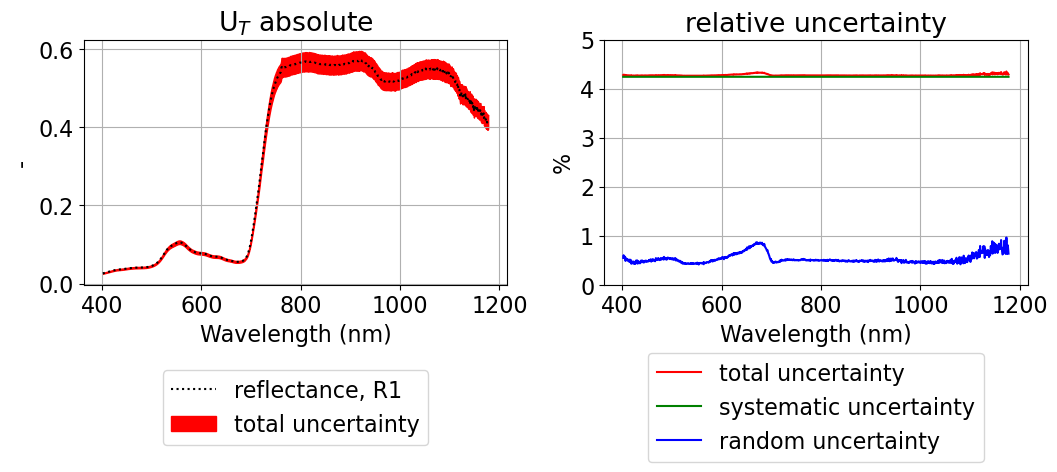

In [54]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = R1
ur = R1_ut
c = 'red'
utype = 'total'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='reflectance, R1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute")
ax.set_ylabel('-')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, R1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, R1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty")
ax.set_ylabel('%')
ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

## 4-7
### Export

Reflectance with its uncertainty are the inputs to the next steps retrieval and biochemical model runs.

Let's save it as a table .csv (dataframe)

[back to TOC](#TOC)

In [55]:
df = pd.DataFrame(
    {'wl': Wvl,
     'refl': R1,
     'refl_u': R1_ut
    }).set_index('wl')

df.head()

,refl,refl_u
wl,,
401.82374,0.026258,0.001124
402.61047,0.026386,0.001131
403.39714,0.026713,0.001144
404.18373,0.026888,0.001151
404.97025,0.027230,0.001166


In [56]:
# df.to_csv('R1_ut.csv')

# 5
## Correlation matrix (FYI)

[back to TOC](#TOC)

Correlation matrix is a diagnostic tool that helps identify the patterns of uncertainty and analyze their interdependence. In our case, the dependence is possible in the spectral domain.

The workflow is the same as in the previous notebook

To construct the correlation matrix of total uncertainty we have to follow four steps
1. define correlation matrices of $U_R$ and $U_S$
2. convert correlation matrices to covariance matrices
3. compute total covariance matrix (sum of radom and systematic covariances)
4. convert total covariance matrix to total correlation matrix

Correlation matrices are symmetric, meaning the elements above and below the main diagonal are the same. Yet, we will not mask any part of it


### necessary functions

In [57]:
def compute_cor_mat(ur, us):
    ur_corr = np.eye(len(ur))
    ur_cov = punpy.convert_corr_to_cov(ur_corr, ur)
    
    us_corr = np.ones([len(us), len(us)])
    us_cov = punpy.convert_corr_to_cov(us_corr, us)
    
    cov = ur_cov + us_cov
    corr = punpy.correlation_from_covariance(cov)

    return corr

In [58]:
def plot_cor_mat(cor_mat, symbol, ax=None, vmin=0.9):
    if ax is None:
        _, ax = plt.subplots()
    
    im = ax.imshow(cor_mat, vmin=vmin, vmax=1)
    plt.colorbar(im, label='correlation coefficient')
    ax.set_title(symbol)
    
    n_wl = Wvl.size
    ticks = ax.get_xticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_xticks(ticks);
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Wavelength (nm)")
    
    ticks = ax.get_yticks()
    ticks = ticks[(ticks >= 0) & (ticks < n_wl)].astype(int)
    tick_labels = Wvl[ticks].astype(int)
    ax.set_yticks(ticks);
    ax.set_yticklabels(tick_labels)
    ax.set_ylabel("Wavelength (nm)")

### computations

In [59]:
L1_corr = compute_cor_mat(L1_ur, L1_us)

E1_corr = compute_cor_mat(E1_ur, E1_us)

R1_corr = compute_cor_mat(R1_ur, R1_us)

### plotting

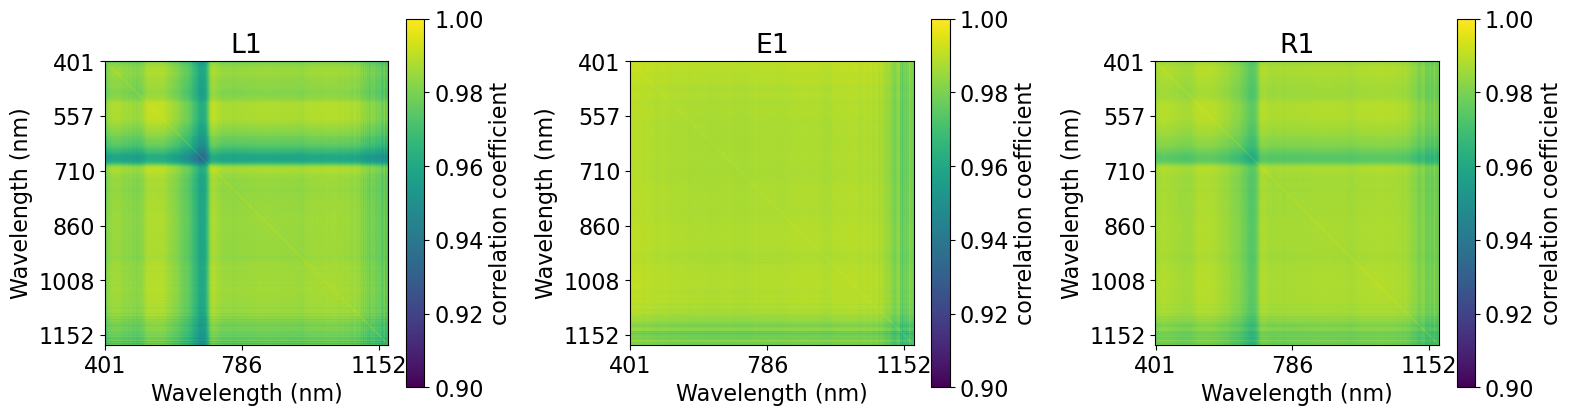

In [60]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
units = '%'

ax = axs[0]
plot_cor_mat(L1_corr, 'L1', ax)

ax = axs[1]
plot_cor_mat(E1_corr, 'E1', ax)

ax = axs[2]
plot_cor_mat(R1_corr, 'R1', ax)